 ## Importing libraries 

In [6]:
import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, make_scorer, f1_score
from sklearn.metrics import ConfusionMatrixDisplay

## Function to record perfromance metrics

In [7]:
def score_recorder(classifier_name, ml_model, X_train, y_train, X_test, y_test):
    """
    A function to record the precision and recall score for different
    classifier trials to comapre the performance. 
    Classifier_name : a string name of the classifier used for study.
    ml_model : The ML model trained for classification problem. 
    X_train : The train data.
    y_train : The train labels
    X_test : The test data.
    y_test : The test labels
    """
    y_pred_test = ml_model.predict(X_test) 
    
    scores = {
        'Train_accuracy' : ml_model.score(X_train, y_train),
        'Test_accuracy' : ml_model.score(X_test, y_test),
        'Balanced_accuracy' : balanced_accuracy_score(y_test, y_pred_test),
        'Test_Precision' : precision_score(y_test, y_pred_test, pos_label = "not_ready"),
        'Test_Recall' : recall_score(y_test, y_pred_test, pos_label="not_ready"),
        'Test_F1_score' : f1_score(y_test, y_pred_test, pos_label = "not_ready" )
    }
    
    df_scores = pd.DataFrame(scores, index = [classifier_name])
    
    return df_scores

In [8]:
# for reproducibility of the models. 
random_state = 0

## Data preprocessing and labelling. 

In [9]:
# Directory where all Excel files are stored
current_dir = Path().resolve()
HT_data_path = current_dir/'Data_feature_imp'/'2024-04-10_outputfile_itr_1_size_1300_HT.xlsx'
MT_data_path = current_dir/'Data_feature_imp'/'2024-04-10_outputfile_itr_1_size_1300_MT.xlsx'

# Load the data from excel
HT_df = pd.read_excel(HT_data_path)
MT_df = pd.read_excel(MT_data_path)

# sample number as column index 
HT_df.set_index('Sample Number', inplace = True)
MT_df.set_index('Sample Number', inplace = True)

# Define your threshold
threshold_cold_hours = 0  # adjust as needed
threshold_shd = 0

# Loop through each sample
for sample in HT_df.index:
    # Get heating demand and cold hours for each sample in HT supply
    HT_heating_demand = HT_df.loc[sample, 'Heating_demand']
    HT_cold_hours = HT_df.loc[sample, 'Underheated_hours']
    
    # Get heating demand and cold hours for each sample in MT supply
    MT_heating_demand = MT_df.loc[sample, 'Heating_demand']
    MT_cold_hours = MT_df.loc[sample, 'Underheated_hours']
    
    # Check for LTH readiness
    # if heating demands or cold hours in MT supply are higher than those in HT supply
    # then sample is "not ready: 0" for MT
    
    if abs(MT_heating_demand - HT_heating_demand) < threshold_shd or abs(MT_cold_hours - HT_cold_hours) > threshold_cold_hours:
        MT_df.loc[sample, 'label'] = "not_ready"  # Not ready
    # if not then the sample is "ready = 1" for MT
    else:
        MT_df.loc[sample, 'label'] = "ready"  # Ready

## Setting features and target

In [10]:
# Access the features
MT_df.columns

Index(['Construction Year', 'orientation', 'compactness_ratio', 'position',
       'WWR', 'Rc_Gr', 'Rc_Wl', 'Rc_Rf', 'U_Gz', 'U_Dr', 'Inf', 'Vent_sys',
       'Temp_set', 'Heating_demand', 'Underheated_hours', 'label'],
      dtype='object')

> * We will drop `Construction Year` because it is an identifier of the sample and for only reference puporses.
> * `Position` is also dropped because it is taken care of in the CR paramater.
> * `Heating_demand` and `Underheated_hours` will also be dropped because they are the simulation outputs.
> * However, we want to understand the combined effect of heating demand and thermal comfort on making a sample `ready` or `not ready` using the `Lower Temperature Heating Ready` definition developed in our previous research and described in section `3.2.1.4. Simulation outputs` in the journal paper.
>>Therefore, `label` column is our <b> target </b> and
>>`orientation, compactness ratio, WWR, Insulation (wall, floor, roof, windows, door), infilteration, ventilation system` and `heating setpoint` are the <b> features </b> for our classification problem. 

In [11]:
data = MT_df.drop(columns=['Construction Year', 'position', 'label', 'Heating_demand', 'Underheated_hours'])
target = MT_df['label']

data

,orientation,compactness_ratio,WWR,Rc_Gr,Rc_Wl,Rc_Rf,U_Gz,U_Dr,Inf,Vent_sys,Temp_set
Sample Number,,,,,,,,,,,
1,45,1.529054,38,1.832984,2.894253,3.070572,2.272061,3.164669,0.697760,3,20
2,90,0.698621,40,2.002541,1.802082,1.144478,4.432564,3.158600,1.936111,1,21
3,315,0.716121,38,2.487997,3.959967,2.632862,1.740797,2.804525,0.511640,3,19
4,270,1.050176,40,0.475517,1.697988,0.809333,3.681028,3.295890,1.070581,3,19
5,315,0.978574,38,3.283023,2.405441,2.832286,3.682901,3.106230,0.384416,3,18
...,...,...,...,...,...,...,...,...,...,...,...
1296,225,0.730752,40,2.064450,1.512731,0.630137,2.810287,3.045490,1.348307,3,19
1297,270,1.821664,40,0.693137,2.314357,1.649296,2.881039,3.260524,1.714934,1,20
1298,0,0.496014,33,1.234653,2.867767,1.430473,3.515188,3.254380,0.975809,3,20


> * Random Forest Classifier can handel the data without scaling and encoding, so the data was used as such. 

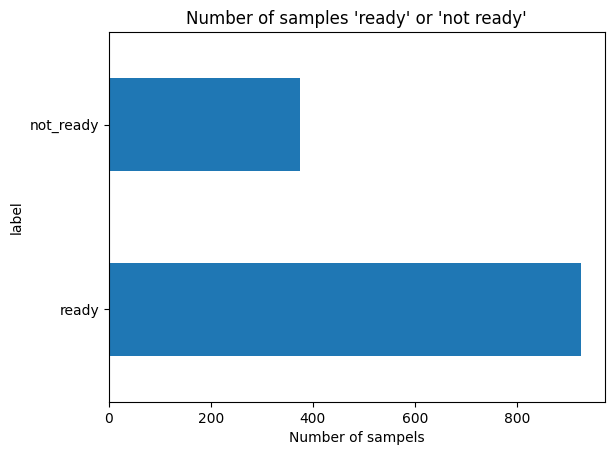

In [12]:
# Visualise the distribution of the target

target.value_counts().plot.barh()
plt.xlabel("Number of sampels")
_ = plt.title("Number of samples 'ready' or 'not ready'")

In [13]:
target.value_counts()

label
ready        926
not_ready    374
Name: count, dtype: int64

In [14]:
target.value_counts(normalize=True)*100

label
ready        71.230769
not_ready    28.769231
Name: proportion, dtype: float64

> * As it can be observed that the we have imbalanced sample. Therefore, the trained model will be biased towards classifying a sample to be `"ready"`. 

## Train-Test split

In [15]:
data_train, data_test, target_train, target_test = train_test_split(
    data, 
    target, 
    shuffle=True, 
    random_state=random_state, 
    test_size=0.2
)

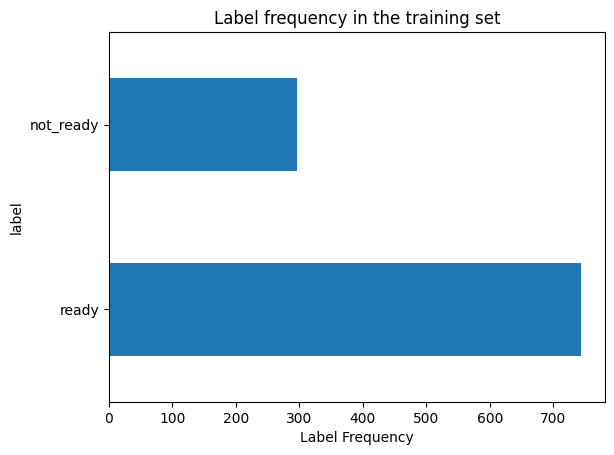

In [16]:
target_train.value_counts().plot.barh()
plt.xlabel("Label Frequency")
_ = plt.title("Label frequency in the training set")

In [17]:
target_train.value_counts()

label
ready        744
not_ready    296
Name: count, dtype: int64

In [18]:
target_train.value_counts(normalize=True)*100

label
ready        71.538462
not_ready    28.461538
Name: proportion, dtype: float64

> * This also demonstrates that the training set made from our dataset is imbalanced with around <b>72%</b> `'ready'` and <b>28%</b> `not ready'`.
>* The imbalanced dataset will affect the generalisation ability of the model as the dataset is biased towards predicting a sample being `ready`. 

## Prepare baseline performance. 

>During class imbalance the accuracy of the Random forest (RF) classifier is linked to its ability to correctly predict the positive class `'ready'`. We can illustrate the issue using a dummy classifier as a baseline.

##### Dummy classifier

In [19]:
dummy_classifier = DummyClassifier(strategy="most_frequent")

dummy_classifier.fit(data_train, target_train)

accuracy_dummy = dummy_classifier.score(data_test, target_test)

print(f"The accuracy of the dummy classifier: {accuracy_dummy}")

The accuracy of the dummy classifier: 0.7


##### Random Forest Classifier

In [20]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=2, random_state=random_state)

rf.fit(data_train, target_train)

accuracy_rf = rf.score(data_test, target_test)

print(f"The accuracy of the rf classifier: {accuracy_rf}")

The accuracy of the rf classifier: 0.8384615384615385


> * It is observed, the dummy classifier which always predicts label `'ready'` has an accuracy of <b> 70% </b> where as the random forest classifier that considered both categiories has an accuracy of <b> 83.8% </b>. 

> * Accuracy indicates how accurate the model in predicting the labels. 
> * Literature suggests that in the case of class imbalance problems reporting `'accuracy'` is not recommended. Instead one should use `'recall'` and '`precision'` score or '`balanced accuracy'` isntead of just '`accuracy'`. 

##### Balanced Accuracy

In [21]:
target_predicted_test = rf.predict(data_test)

balanced_accuracy = balanced_accuracy_score(target_test, target_predicted_test)

print(f"Balanced Accuracy : {balanced_accuracy:.3f}")

Balanced Accuracy : 0.775


> * The `Balanced Accuracy` scores the average of recall obtained on each label.
> * The `Balanced Accuracy` of <b>0.775</b> means that the model is correct <b>77.5%</b> of the time on average when predicting both `ready` and `not ready`. This metric gives equal weigths to both labels. 

##### Recall and Precision score .. Visualising confusion matrix

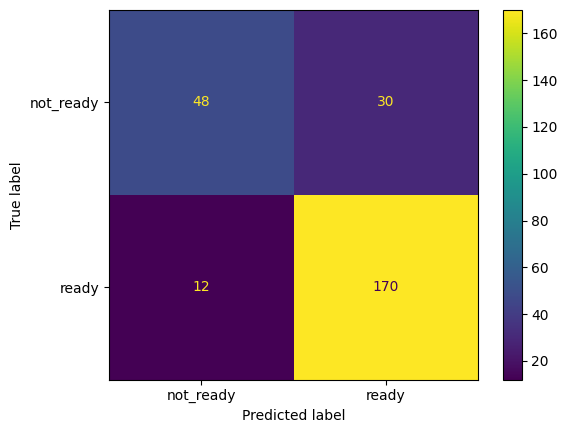

In [22]:
_ = ConfusionMatrixDisplay.from_estimator(rf, data_test, target_test)

Another measure to evalute the performance of the model is to plot a confusion matrix.
1. <b> True Negatives (TN): </b> The samples that are `not_ready` and were correctly predcited to be `not_ready` [48]
2. <b> True Positives (TP): </b> The samples that are `ready` and were correctly predcited to be `ready` [170]
3. <b> False Negative (FN): </b> The samples that are `not ready` and were incorrectly  predcited to be `ready` [30]
4. <b> False Positves (FN): </b> The samples that are `ready` and were incorrectly predcited to be not `not ready` [12]

### In this case we will switch the labels to evaluate the minority negative class "not ready" 

In [23]:
precision = precision_score(target_test, target_predicted_test, pos_label="not_ready")
recall = recall_score(target_test, target_predicted_test, pos_label="not_ready")

print(f"Precision score: {precision:.3f}")
print(f"Recall score: {recall:.3f}")

Precision score: 0.800
Recall score: 0.615


> * The `Precision score` of <b> 0.800 </b> means that when the model predicts a sample is `not_ready` then it is accurate about <b>80%</b> of the time. 
> * The `Recall score` of <b> 0.615 </b> means that out of all the actual samples that are `not_ready`, the model correctly identifies <b>61.5%</b> them. Rest of the `not_ready` samples will be missed by the model. 

##### Using the helper function to record the scores for comparitive analysis. 

In [24]:
dummy = score_recorder("dummy", dummy_classifier, data_train, target_train, data_test, target_test)
random_forest = score_recorder("Random forest", rf, data_train, target_train, data_test, target_test)

c:\users\prateekwahi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
pd.concat([dummy, random_forest], axis = 0)

,Train_accuracy,Test_accuracy,Balanced_accuracy,Test_Precision,Test_Recall,Test_F1_score
dummy,0.715385,0.700000,0.500000,0.0,0.000000,0.000000
Random forest,1.000000,0.838462,0.774725,0.8,0.615385,0.695652


# Imbalance data set solutions. 

> From the literature, the study uses the **Cost-sensitive** method to solve the problem of imbalanced classes.
> * <b>Cost-sensitive</b> : Assigning high cost to missclassify the minority class.  

### Testing Cost - sensitive method

> The cost-sensitive method is applied using the **class_weight** parameter in the random forest classifier. Weights are calculated based on scikit learn documentation.
> * $\text{Class weight} = \frac{\text{Total Samples}}{\text{Number of Classes} \times \text{Number of Samples per Class}}$

In [26]:
# calculating the weights as per sklearn documentation
ready = len(data)/(2 * target.value_counts()["ready"])
not_ready = len(data)/(2 * target.value_counts()["not_ready"])

In [27]:
# Randomforest classifier with eighted class
rf_weight = RandomForestClassifier(
    n_estimators= 100, 
    n_jobs=2, 
    random_state=random_state, 
    class_weight={'not_ready':not_ready, 'ready':ready}
    # class_weight="balanced_subsample"
)

rf_weight.fit(data_train, target_train)

RandomForestClassifier(class_weight={'not_ready': 1.7379679144385027,
                                     'ready': 0.7019438444924406},
                       n_jobs=2, random_state=0)

In [28]:
weighted_class = score_recorder("RF_weighted_class", rf_weight, data_train, target_train, data_test, target_test)
pd.concat([dummy, random_forest, weighted_class])

,Train_accuracy,Test_accuracy,Balanced_accuracy,Test_Precision,Test_Recall,Test_F1_score
dummy,0.715385,0.700000,0.500000,0.000000,0.000000,0.000000
Random forest,1.000000,0.838462,0.774725,0.800000,0.615385,0.695652
RF_weighted_class,1.000000,0.850000,0.782967,0.842105,0.615385,0.711111


> * In the context of this study it is important to have a balanced Precision and Recall Score. 
> * <b>Precision Score</b> : Reducing `False Positives` by not labelling a sample `ready` when it is actually `not ready`. 
>> * <b><i>False Positives: </i></b> These occur when the model incorrectly predicts the positive class(`ready`). For example, when predicting whether a house is ready for MT or LT supply, a false positive would mean that the model predicts a house is ready when it’s actually not. The consequence might be that resources are wasted on a house that doesn’t need them
> * <b> Recall Score </b> : Reducing `false negatives` by recoginising all the samples that are `ready`. 
>> * <b><i>False Negatives: </i></b> These occur when the model incorrectly predicts the negative class (`not ready`). In the same example, a false negative would mean that the model predicts a house is not ready when it actually is. The consequence might be that a house that could benefit from MT or LT supply doesn’t receive it.

> * Therefore, in the context of this study, the model with a balanced precision and recall score is to be used for feature importance.
> * In this case, the RF_weighted model performs better than RF. Therefore, the RF_weighted model is used to extract Feature importances. 

# Feature Importances

<Axes: >

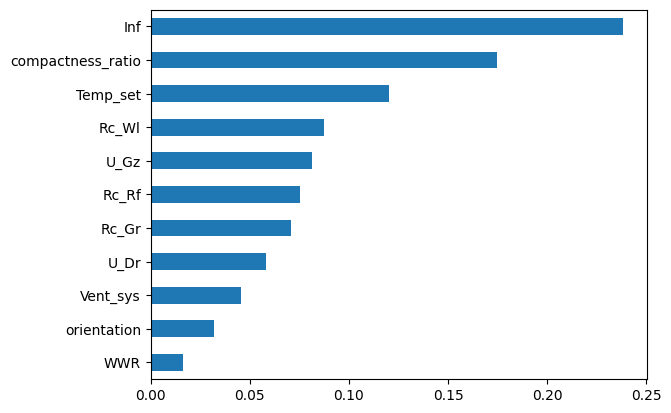

In [32]:
importances_weight = rf_weight.feature_importances_
feature_names_weight = rf_weight.feature_names_in_
pd.Series(importances_weight, feature_names_weight).sort_values(ascending=True).plot.barh()

In [33]:
pd.Series(importances_weight, feature_names_weight).sort_values(ascending=False)

Inf                  0.238291
compactness_ratio    0.174847
Temp_set             0.119962
Rc_Wl                0.087302
U_Gz                 0.081164
Rc_Rf                0.075138
Rc_Gr                0.070637
U_Dr                 0.058338
Vent_sys             0.045786
orientation          0.032101
WWR                  0.016434
dtype: float64